# 🌳 Linear Regression Model

## 👽 Load and Summarize

In [125]:
# Required libraries
# import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# !pip install --upgrade pandas
import pandas as pd
# print(pd.__version__) # I am having trouble with pandas and dataframes...
import seaborn as sns
# print(sns.__version__)  # Should be 0.11.0 or higher so that `histplot() works
# !pip install --upgrade seaborn
from sklearn.feature_selection import VarianceThreshold

# Load the data
data = pd.read_csv('./data/train_data.csv')

# print(data.shape)
# data.describe()

## 🧯 Suppress the `FutureWarning`

In [39]:
# import warnings
# warnings.simplefilter("ignore", category=FutureWarning)

## 🧼 Clean the Dataset

In [126]:
# # Convert all object columns to strings
string_cols = ['protocol_type', 'service', 'flag']

data = pd.get_dummies(data, columns=string_cols, drop_first=True)

data = data.dropna()

# print((data['is_host_login'] == 1).count()) # 25192 empty, so I will drop
# Drop `is_host_login`

# Search for bad columns
constant_cols = [col for col in data.columns if data[col].nunique(dropna=False) == 1]
# print("Useless columns:", constant_cols)  Useless columns: ['num_outbound_cmds', 'is_host_login']
# "Let it all drop" - Modest Mouse
data = data.drop(columns=constant_cols)

# print(data.dtypes)

# Convert the label column
data['class'] = data['class'].map({'normal': 0, 'anomaly': 1})


# Get the binary columns for logistic regression
binary_cols = []

# Get the numeric clumns
numeric_cols = data.select_dtypes(include='number').columns

for col in data.select_dtypes(include='number').columns:
    unique_vals = sorted(data[col].dropna().unique())
    if unique_vals == [0, 1]:
        binary_cols.append(col)

# print("Binary columns:", binary_cols)
binary_cols.remove('num_shells')
# print(binary_cols)
# Separate the numeric and binary columns

numeric_cols = [col for col in numeric_cols if col not in binary_cols]

# print(data.isna().sum().sort_values(ascending=False).head(10)) # No NaN
# inf_mask = np.isinf(data) # No -inf/inf
# print(inf_mask.sum().sort_values(ascending=False).head(10)) # No -inf/inf

## 🐫 Removing Low Variance Cells

In [138]:
# Fit the selector
selector = VarianceThreshold(threshold=0.001)
selector.fit(data[numeric_cols])  # call .fit() before accessing .variances_

# Now safe to access .variances_
low_variance = [col for col, var in zip(numeric_cols, selector.variances_) if var < 0.00001]

print("Low-variance features:\n" + "-" * 100)

if low_variance:
    print("-" * 100)
    print(data[low_variance].describe())
    print("-" * 100)
    print(data.groupby('class')[low_variance].mean())
else:
    print("No low-variance features found.")

Low-variance features:
----------------------------------------------------------------------------------------------------
No low-variance features found.


In [5]:
# Drop these rows because they don't help
# data = data.drop(columns=low_variance) # I am going to keep them for the moment

### 🎆 Remove Unusable Values

In [128]:
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()

## 🌲 Build the Random Forest Model

In [135]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Split
X = data.drop(columns = 'class')
y = data['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42069) # Nice

# print(X)

### 🚂 Train the Model

In [130]:
model = RandomForestClassifier(
    n_estimators=100,       # number of trees
    max_depth=None,         # can tune
    class_weight='balanced', # for imbalance, not that there is any
    random_state=42069, # Nice
    n_jobs=-1
)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42069)

### 🐊 Evaluate the Model

In [131]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, r2_score

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluation
print("ROC AUC (Test):", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

print("-" * 100)
print("Train classification report:")
print(classification_report(y_train, y_pred_train))

print("-" * 100)
print("Test classification report:")
print(classification_report(y_test, y_pred_test))

ROC AUC (Test): 0.9999199662196663
----------------------------------------------------------------------------------------------------
Train classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10087
           1       1.00      1.00      1.00      8807

    accuracy                           1.00     18894
   macro avg       1.00      1.00      1.00     18894
weighted avg       1.00      1.00      1.00     18894

----------------------------------------------------------------------------------------------------
Test classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3362
           1       1.00      0.99      1.00      2936

    accuracy                           1.00      6298
   macro avg       1.00      1.00      1.00      6298
weighted avg       1.00      1.00      1.00      6298



### 🦖 Confusion Matrix

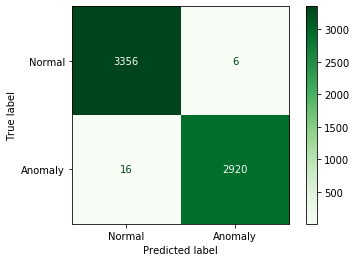

In [132]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Normal', 'Anomaly']
)

# Plot it
disp.plot(cmap='Greens')

### 🥨 Viewing Results

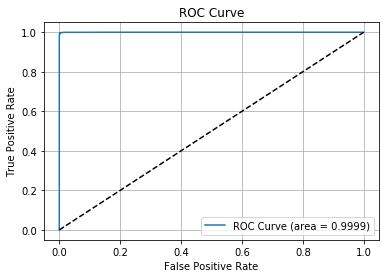

In [134]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC Curve (area = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

#### 🥐 Cross-Validating the Results

In [139]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(rf, X, y, cv=5, scoring='roc_auc'))

[0.99997674 0.99998623 0.99995535 0.99995979 0.99991538]


### 🎺 Ranking Important Features

In [136]:
# Feature importances as a Series
importances = pd.Series(rf.feature_importances_, index=X.columns)

# Sort descending
importances = importances.sort_values(ascending=False)

# Show top 20
print(importances.head(20))

dst_bytes                      0.149949
src_bytes                      0.112013
same_srv_rate                  0.063721
logged_in                      0.060237
dst_host_srv_count             0.055801
diff_srv_rate                  0.052469
dst_host_same_srv_rate         0.042717
count                          0.039476
dst_host_serror_rate           0.035847
dst_host_diff_srv_rate         0.033700
flag_SF                        0.032602
serror_rate                    0.025736
dst_host_same_src_port_rate    0.021574
dst_host_srv_serror_rate       0.020900
service_http                   0.020874
dst_host_srv_diff_host_rate    0.018993
dst_host_count                 0.018953
srv_serror_rate                0.018376
srv_count                      0.016672
dst_host_rerror_rate           0.014249
dtype: float64


#### 🌵 Plot the Important Features

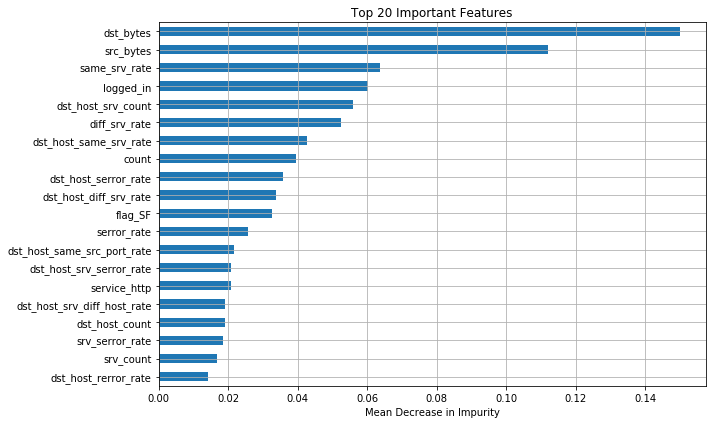

In [137]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
importances.head(20).plot(kind='barh')
plt.title('Top 20 Important Features')
plt.xlabel('Mean Decrease in Impurity')
plt.gca().invert_yaxis()  # Most important on top
plt.grid(True)
plt.tight_layout()
plt.show()